In [93]:
#This is a starting point
#uncomment below to install merlin library
#!pip install merlin, nvtabular, merlin.models
#I had to downgrade keras to 12.2.0 there maybe issues regarding tensorflow in the future
#run lines below if you have also have an error ab not finding a keras package

#pip uninstall keras
#pip install keras==2.12.0


#These are the same imports from
#https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb
import os
import pandas as pd
import numpy as np
import nvtabular as nvt
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import polars as pl

from sklearn.model_selection import train_test_split

from merlin.models.utils.example_utils import workflow_fit_transform
import merlin.io
import tensorflow as tf

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
from nvtabular.ops import *
from merlin.core.utils import download_file
from merlin.schema.tags import Tags

### To-do

1. Clean data << Prices on user_interactions are not what they should be... probably is more
2. EDA
3. Transform timestamps
4. Find out why certain things are crashing the model
5. Learn about models and optimizers

In [94]:
file_path = '/Users/andrew/Desktop/projects/recsys_data/2023-10-05 9_23pm (2).csv'

In [95]:
def read_target_sample(file_path, sample_frac = 1, rand = 101, order_weight = 1, added_weight = .5):
    df = pd.read_csv(file_path).dropna() 
    #After cleaning should not need dropna()
    df['TARGET'] = 0
    #Different values for different event_names
    df.loc[df['EVENT_NAME'] == 'order', 'TARGET'] = order_weight
    df.loc[df['EVENT_NAME'] == 'product_added', 'TARGET'] = added_weight

    df = df[df['TARGET'] > 0]
    df = df.sample(frac = sample_frac, random_state = rand)
    return df

# Cleaning

# TRANSFORM USER DF

# TRANSFORM ITEM DF

In [9]:
#Make sure these don't have weird 0 values (like num product_viewed < order), if they do get rid of them especially the last function

In [10]:
def count_product_views(df):
    """
    count num of times each user has viewed a unique STYLE
    
    return: a new column with the count of product views appended to each unique USER_ID and STYLE combination
    """
    return df[df['EVENT_NAME'] == 'product_viewed'].groupby(['USER_ID', 'ITEM_ID']).size().reset_index(name='VIEWS')

In [11]:
def bought_ratio(df):
    """
    for each unique item how many people bought divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    hold = df[df['EVENT_NAME'] == 'order'].groupby('ITEM_ID').size().reset_index(name='BUY_RATIO')
    num_users = df['USER_ID'].nunique()
    return hold

In [12]:
def viewed_ratio(df):
    """
    for each unique item how many people viewed divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    return df[df['EVENT_NAME'] == 'product_viewed'].groupby('ITEM_ID')['USER_ID'].nunique().reset_index(name='viewers')

In [13]:
def cart_ratio(df):
    """
    for each unique item how many people added cart divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    cart_counts = df[df['EVENT_NAME'] == 'add_to_cart'].groupby('ITEM_ID')['USER_ID'].nunique()
    total_users = df['USER_ID'].nunique()
    cart_ratio = cart_counts / total_users
    return cart_ratio

In [14]:
def viewed_to_bought_ratio(df):
    """
    the number of views divided by bought... aka do people need to view it many times before buying it or not
    
    """
    bought_ratio_df = bought_ratio(df)
    viewed_ratio_df = viewed_ratio(df)
    viewed_to_bought_ratio = pd.merge(bought_ratio_df, viewed_ratio_df, on='ITEM_ID', how='left')
    viewed_to_bought_ratio['buy_to_view_ratio'] = viewed_to_bought_ratio['viewers'] / viewed_to_bought_ratio['buyers']
    return viewed_to_bought_ratio.dropna() # only function with nan values i had to drop

In [15]:
#viewed_to_bought_ratio(df).sort_values('buy_to_view_ratio', ascending=False)

## I am going to try and feature engineer on item_df and user_df then merge with negative sampled df.

## Also going to add in testing

In [39]:
def negative_sample(df, multiplier = 1):
    negative_df = df[['USER_ID', 'ITEM_ID', 'TARGET']]
    sections = df.shape[0]//10000
    negative_data = []
    item_map = df['ITEM_ID'].unique()
    rng = np.random.default_rng()
    zero_multiplier = multiplier #https://datascience.stackexchange.com/questions/6939/ratio-of-positive-to-negative-sample-in-data-set-for-best-classification
    #The above datascience stackexchange says 1:1 is a good ratio, i didn't look into it that much tho

    for chunk in np.array_split(df, sections):
        user_id_counts = pd.value_counts(chunk.USER_ID)
        item_ids = []
        for user_id, count in user_id_counts.items():
            item_ids.append(np.random.randint(low = 0, high = item_map.shape[0], size = count*zero_multiplier))
        item_ids = np.concatenate(item_ids)
        negative_data.append(pd.DataFrame({'USER_ID': np.repeat(user_id_counts.index, repeats = user_id_counts.values*zero_multiplier),
                                           'ITEM_ID': item_map[item_ids],
                                           'TARGET': 0}))
    negative_data.append(negative_df)
    sample_data = pd.concat(negative_data)
    sample_data = sample_data.reset_index(drop = True)
    return sample_data

### Merging TEST IN FUTURE

In [43]:
def merge(negative_df, df):
    item_df = df[['STYLE', 'USER_ID', 'PRICE_INFORMATION', 'AVG_REVIEW_SCORE',
              'ITEM_ID', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
              'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'EVENT_NAME']]
    
    user_df = df[['USER_ID', 'ITEM_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME', 'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
              'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT']]
    
    df_subset = negative_df.merge(user_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['USER_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')
    df_subset = df_subset.merge(item_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['ITEM_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')
    return df_subset

In [97]:
#num rows
def train_valid_split_to_parquet(df, ratio = .2):
    data_size = df.shape[0]

    train_split_ratio = int(ratio * data_size)

    train = df[:-train_split_ratio].to_parquet("train.parquet")
    valid = df[-train_split_ratio:].to_parquet("valid.parquet")

# NVTabular

In [78]:
def nvtabular_pipeline():
    categorical_user_features = ['COUNTRY']
    categorical_item_features = ['STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP']
    user_id = ["USER_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsUserID()
    item_id = ["ITEM_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsItemID()
    item_features = categorical_item_features >> Categorify(dtype = "int32") >> TagAsItemFeatures()
    user_features = categorical_user_features >> Categorify(dtype = "int32") >> TagAsUserFeatures()
    
    target = (
        #Turn categorical into continuous
        nvt.ColumnSelector(["TARGET"])
        #>> LambdaOp(lambda col: (col > 0).astype("int32")) CHANGES ALL WEIGHTS TO 1 
        >> AddTags(["categorical_classification", "target"]) #categorical look into it
        >> Rename(name="INTERACTION_BINARY")
    )
    
    CLICKSTREAM_EVENTS_TOTAL = (
        nvt.ColumnSelector(['CLICKSTREAM_EVENTS_TOTAL'])
        >>FillMissing(1)
        >>LogOp()
        >>Normalize()
        >>LambdaOp(lambda col: col.astype("float32"))
        >>TagAsUserFeatures()
    )

    PRICE_INFORMATION = (
        ['PRICE_INFORMATION']
        >>FillMissing(1)
        >>LogOp()
        >>Normalize()
        >>LambdaOp(lambda col: col.astype("float32"))
        >>TagAsItemFeatures()
    )

    AVG_REVIEW_SCORE = (
        ['AVG_REVIEW_SCORE']
        >>Normalize()
        >>LambdaOp(lambda col: col**2)
        >>TagAsItemFeatures()
    )

    INTERACTION_TIMESTAMP = (
        nvt.ColumnSelector(['DAYS_SINCE_INTERACTION'])
        #>>Normalize()
        >>TagAsUserFeatures()
    )

    DAYS_SINCE_LAST_VISIT = (
        nvt.ColumnSelector(['DAYS_SINCE_LAST_VISIT'])
        >>TagAsUserFeatures()
    )
    categorical_features = (categorical_item_features) #Just a place holder... redo with better categories
    user_cat_features = (user_features)
    label = nvt.ColumnSelector(['TARGET'])
    te_features = categorical_features >> TargetEncoding(label)
    user_feats = user_cat_features >> TargetEncoding(label)
    te_features_norm = te_features >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
    user_cat_features_norm = user_feats >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
    output = (
        user_id + 
        item_id +
        target +
        CLICKSTREAM_EVENTS_TOTAL + 
        te_features +
        user_feats +
        # INTERACTION_TIMESTAMP +
        # DAYS_SINCE_LAST_VISIT + 
        #PRICE_INFORMATION + #<< THIS CAUSES MODEL TO CRASH AND BURN
        AVG_REVIEW_SCORE
    )

    workflow_fit_transform(output, 'train.parquet', 'valid.parquet', 'integration') 
    train = merlin.io.Dataset(
        os.path.join("integration", "train"), engine="parquet"
    )
    valid = merlin.io.Dataset(
        os.path.join("integration", "valid"), engine="parquet"
    )
    return train,valid

## Model

In [100]:
def preprocessing():
    df = read_target_sample(file_path)
    neg_df = negative_sample(df)
    merged_df = merge(neg_df, df) #merge doesn't work right ofc
    train_valid_split_to_parquet(merged_df)
    train, valid = nvtabular_pipeline()
    return train, valid

In [101]:
def ncf_model(train, valid, lr = .0175, epoch = 1):
    model = mm.benchmark.NCFModel(
        train.schema,
        embedding_dim=64,
        mlp_block=mm.MLPBlock([128, 64]),
        prediction_tasks=mm.BinaryOutput(train.schema.select_by_tag(Tags.TARGET).column_names[0]),
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr), run_eagerly=False, metrics=[mm.RecallAt(), mm.NDCGAt()]);
    model.fit(train, validation_data=valid, batch_size=1024, epochs = epoch); #Less epochs, more accurate valid... less accurate train
    print(model.evaluate(valid, batch_size = 1024, return_dict = True))

In [102]:
x1, x2 = preprocessing()
ncf_model(x1, x2)

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Datase

33/33 [==============================] - 0s 1ms/step - loss: 0.6909 - recall_at_10: 0.3865 - ndcg_at_10: 0.3836 - regularization_loss: 0.0000e+00 - loss_batch: 0.6805
{'loss': 0.6909409761428833, 'recall_at_10': 0.4000000059604645, 'ndcg_at_10': 0.39299237728118896, 'regularization_loss': 0.0, 'loss_batch': 0.48897385597229004}


In [30]:
def ncf_pred_hist():
    preds = model.predict(valid, batch_size = 1024)

(array([0.01432651, 0.10112829, 0.64974927, 2.41865162, 5.47356873,
        9.3712216 , 6.11657611, 3.16447276, 0.4997423 , 0.01769745]),
 array([0.15684295, 0.19277909, 0.22871524, 0.26465139, 0.30058753,
        0.33652368, 0.37245983, 0.40839598, 0.44433212, 0.48026827,
        0.51620442]),
 <BarContainer object of 10 artists>)

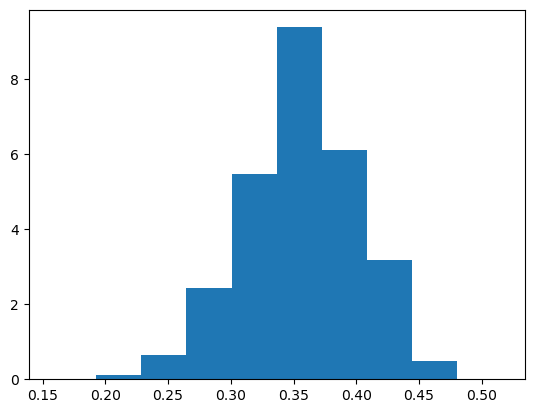

In [31]:
plt.hist(preds, density = True)

# Model

In [86]:
def dlrm_model():
    model_fb = mm.DLRMModel(
        train.schema,
        embedding_dim = 64,
        top_block = mm.MLPBlock([128, 64, 32]),
        bottom_block = mm.MLPBlock([128, 64]),
    )

    model_fb.compile(optimizer = keras.optimizers.Adam(learning_rate = .0175), metrics=[mm.RecallAt(5), mm.NDCGAt(5)])
    model_fb.fit(train, batch_size = 1024, epochs = 1)
    print(model_fb.evaluate(valid, batch_size = 1024, return_dict = True))



In [89]:
ncf_model(train, valid)

33/33 [==============================] - 0s 1ms/step - loss: 0.7304 - recall_at_10: 0.4124 - ndcg_at_10: 0.4118 - regularization_loss: 0.0000e+00 - loss_batch: 0.7171
{'loss': 0.7303604483604431, 'recall_at_10': 0.4227272570133209, 'ndcg_at_10': 0.40844476222991943, 'regularization_loss': 0.0, 'loss_batch': 0.4715523421764374}


In [85]:
preds_2 = model_fb.predict(valid, batch_size = 1024)
plt.hist(preds_2, density = True)

NameError: name 'model_fb' is not defined